# Env

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,accuracy_score,explained_variance_score
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from bayes_opt import BayesianOptimization
from sklearn.metrics import make_scorer
from copy import deepcopy


# Evaluation Function

In [ ]:
def evaluate_model_across_splits(
    model,
    X,
    y,
    test_sizes=(0.1, 0.2, 0.3, 0.4, 0.5),
    n_repeats=30,
    random_state=42
):
    X = np.asarray(X)
    y = np.asarray(y).ravel()
    
    rng = np.random.RandomState(random_state)
    results = []

    for ts in test_sizes:
        r2_list, rmse_list = [], []
        seeds = rng.randint(0, 10_000_000, size=n_repeats)

        for seed in seeds:
            X_tr, X_te, y_tr, y_te = train_test_split(
                X, y, test_size=ts, random_state=seed
            )

            est = deepcopy(model)
            est.fit(X_tr, y_tr)
            y_pred = est.predict(X_te)

            r2 = r2_score(y_te, y_pred)
            rmse = np.sqrt(mean_squared_error(y_te, y_pred))
            r2_list.append(r2)
            rmse_list.append(rmse)

        results.append({
            "test_size": ts,
            "R2_mean": np.mean(r2_list),
            "R2_std": np.std(r2_list, ddof=1),
            "RMSE_mean": np.mean(rmse_list),
            "RMSE_std": np.std(rmse_list, ddof=1),
        })

    return pd.DataFrame(results)


In [ ]:
def evaluate_model_across_splits_svr(
    model,
    X,
    y,
    y_scaler=None,                
    test_sizes=(0.1, 0.2, 0.3, 0.4, 0.5),
    n_repeats=30,
    random_state=42
):

    X = np.asarray(X)
    y = np.asarray(y).ravel()

    rng = np.random.RandomState(random_state)
    results = []

    for ts in test_sizes:
        r2_list, rmse_list = [], []
        seeds = rng.randint(0, 10_000_000, size=n_repeats)

        for seed in seeds:
            X_tr, X_te, y_tr, y_te = train_test_split(
                X, y, test_size=ts, random_state=seed
            )

            est = deepcopy(model)
            est.fit(X_tr, y_tr)
            y_pred = est.predict(X_te)
            y_pred = np.asarray(y_pred).reshape(-1)
            y_te_1d = y_te.reshape(-1)

            if y_scaler is not None:
                y_pred_eval = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
                y_true_eval = y_scaler.inverse_transform(y_te_1d.reshape(-1, 1)).ravel()
            else:
                y_pred_eval = y_pred
                y_true_eval = y_te_1d

            r2   = r2_score(y_true_eval, y_pred_eval)
            rmse = float(np.sqrt(mean_squared_error(y_true_eval, y_pred_eval)))
            r2_list.append(r2)
            rmse_list.append(rmse)

        results.append({
            "test_size": ts,
            "R2_mean":  float(np.mean(r2_list)),
            "R2_std":   float(np.std(r2_list, ddof=1)),
            "RMSE_mean": float(np.mean(rmse_list)),
            "RMSE_std":  float(np.std(rmse_list, ddof=1)),
        })

    return pd.DataFrame(results)

# XGBoost

In [ ]:
selected_features_xgb = ['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'Oxidation state first_Aver', 'Energy cohesive(Brewer)_Aver', 'band gap_Aver','Epit']
df_xgb = df[selected_features_xgb]

In [ ]:
X = df_xgb.drop(columns=['Epit'])
y = df_xgb['Epit']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 165.2239
R² Score: 0.5728


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("最佳参数:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
最佳参数: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"测试集 RMSE: {rmse:.4f}")
print(f"测试集 R²: {r2:.4f}")

测试集 RMSE: 150.1860
测试集 R²: 0.6470


In [ ]:
result = evaluate_model_across_splits(
    model=best_model,
    X=X_scaled,
    y=y,
    test_sizes=(0.1, 0.2, 0.3, 0.4, 0.5),
    n_repeats=30,
    random_state=42
)
result

,test_size,R2_mean,R2_std,RMSE_mean,RMSE_std
0,0.1,0.699992,0.066390,144.481795,14.985019
1,0.2,0.684967,0.054809,146.511179,11.272222
2,0.3,0.682044,0.049113,148.384049,10.640691
3,0.4,0.666414,0.037929,152.557372,7.419538
4,0.5,0.650628,0.031456,157.502399,6.241649


# RF

In [ ]:
selected_features_rf = ['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'band gap_Aver', 'Enthalpy of melting_Aver', 'Charge nuclear effective(Clementi)_Aver', 'Energy cohesive(Brewer)_Aver', 'E_M-M', 'Work function of oxides_Aver','Epit']
df_rf = df[selected_features_rf]
X = df_rf.drop(columns=['Epit'])
y = df_rf['Epit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 156.9107
R² Score: 0.6147


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],           
    'max_depth': [3, 4, 5, 6],               
    'min_samples_split': [2, 4, 6],          
    'min_samples_leaf': [1, 2, 4],           
}
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("最佳参数:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
最佳参数: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"测试集 RMSE: {rmse:.4f}")
print(f"测试集 R²: {r2:.4f}")

测试集 RMSE: 161.1132
测试集 R²: 0.5938


In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# model = RandomForestRegressor(n_estimators=200, random_state=42)
result = evaluate_model_across_splits(
    model=model,
    X=X_scaled,
    y=y,
    test_sizes=(0.1, 0.2, 0.3, 0.4, 0.5),
    n_repeats=30,
    random_state=42
)
result


,test_size,R2_mean,R2_std,RMSE_mean,RMSE_std
0,0.1,0.704471,0.071286,143.194107,14.723722
1,0.2,0.678811,0.058483,147.999985,13.204268
2,0.3,0.676983,0.045579,149.653113,9.844463
3,0.4,0.664631,0.033471,153.007047,6.147856
4,0.5,0.638524,0.032390,160.214985,6.394569


# SVR

In [ ]:
selected_features_svr = ['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'E_M-M', 'band gap_Aver', 'Enthalpy of melting_Aver', 'Gibbs free energy of oxide formation_Aver', 'Oxidation state first_Aver', 'Energy cohesive(Brewer)_Aver', 'S', 'Epit']

In [ ]:
df_svr = df[selected_features_svr]
X = df_svr.drop(columns=['Epit'])
y = df_svr['Epit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # 变成一维向量
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

svr = SVR(kernel='rbf', C=10.0, epsilon=0.01, gamma='scale')
svr.fit(X_train_scaled, y_train_scaled)

y_pred_scaled = svr.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_test 

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 136.0401
R² Score: 0.7104


In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).ravel()
result = evaluate_model_across_splits_svr(
    model=svr,
    X=X_scaled,
    y=y_scaled,
    y_scaler=y_scaler,  
    test_sizes=(0.1, 0.2, 0.3, 0.4, 0.5),
    n_repeats=30,
    random_state=42
)
result


,test_size,R2_mean,R2_std,RMSE_mean,RMSE_std
0,0.1,0.695429,0.075121,145.510277,17.836157
1,0.2,0.689310,0.054251,145.654838,12.060298
2,0.3,0.687209,0.049712,147.113382,10.571857
3,0.4,0.664724,0.040103,153.008160,9.832411
4,0.5,0.650889,0.037010,157.457406,9.143060


# RobustNN

In [3]:
selected_features_nn = selected_features_nn = ['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co','E_M-M', 'Gibbs free energy of oxide formation_Aver', 'Energy of ionization second_Aver','Epit']
df_nn = df[selected_features_nn]
X = df_nn.drop(columns=['Epit'])
y = df_nn['Epit']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.to_numpy().reshape(-1, 1)).flatten()

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [6]:
class RobustNN(nn.Module):
    def __init__(self, input_dim):
        super(RobustNN, self).__init__()
        self.feature_weights = nn.Parameter(torch.ones(input_dim))  # 可学习特征权重
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x * self.feature_weights
        return self.net(x)

def loss_fn_with_l1(output, target, model, l1_lambda=0.01):
    mse_loss = nn.MSELoss()(output, target)
    l1_penalty = l1_lambda * torch.norm(model.feature_weights, p=1)
    return mse_loss + l1_penalty

def train_model(model, train_loader, val_loader, num_epochs=600, patience=80, l1_lambda=0.01, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            preds = model(batch_X).squeeze()
            loss = loss_fn_with_l1(preds, batch_y, model, l1_lambda)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_preds = model(val_X).squeeze()
                val_loss = loss_fn_with_l1(val_preds, val_y, model, l1_lambda)
                val_losses.append(val_loss.item())

        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)

        # print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                # print("Early stopping triggered!")
                break

    model.load_state_dict(best_model_state)

    # 可视化 loss 曲线
    # plt.plot(train_loss_history, label='Train Loss')
    # plt.plot(val_loss_history, label='Val Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title("Training and Validation Loss")
    # plt.grid(True)
    # plt.show()

    return model

def evaluate_model(model, test_loader, y_scaler):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch).squeeze()
            predictions.append(output.cpu().numpy())
            targets.append(y_batch.cpu().numpy())

    preds = np.concatenate(predictions)
    trues = np.concatenate(targets)

    preds_real = y_scaler.inverse_transform(preds.reshape(-1, 1)).ravel()
    trues_real = y_scaler.inverse_transform(trues.reshape(-1, 1)).ravel()

    mae = mean_absolute_error(trues_real, preds_real)
    mse = mean_squared_error(trues_real, preds_real)
    rmse = np.sqrt(mse)
    r2 = r2_score(trues_real, preds_real)


    # print("\n=== 测试集评估结果 ===")
    # print(f"MAE: {mae:.4f}")
    # print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")

    return preds_real, trues_real

In [42]:
model = RobustNN(input_dim=X_train.shape[1])
model = train_model(model, train_loader, test_loader, l1_lambda=0.1)
preds, trues = evaluate_model(model, test_loader, y_scaler)

RMSE: 154.4536
R2: 0.6267


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_parity_train_test(
    trues_train, preds_train, trues_test, preds_test,
    limits=None, s_train=46, s_test=46,
    lw_edge=0.8, lw_diag=2.0, legend_loc='upper left'
):
    fig, ax = plt.subplots(figsize=(6.8, 5), dpi=300)
    ax.scatter(trues_train, preds_train, s=s_train, c='#2ca02c',
               edgecolors='k', linewidths=lw_edge, label='Train', alpha=0.95)
    ax.scatter(trues_test,  preds_test,  s=s_test,  c='#1f77b4',
               edgecolors='k', linewidths=lw_edge, label='Test',  alpha=0.95)

    # all_x = np.concatenate([trues_train, trues_test])
    # all_y = np.concatenate([preds_train, preds_test])
    # if limits is None:
    #     lo = min(all_x.min(), all_y.min())
    #     hi = max(all_x.max(), all_y.max())
    #     pad = 0.05 * (hi - lo + 1e-9)
    #     lo, hi = lo - pad, hi + pad
    # else:
    #     lo, hi = limits
    # ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    lo, hi = -650, 900
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_yticks(np.arange(lo+50, hi + 100, 300))
    ax.set_xticks(np.arange(lo+50, hi + 100, 300))
    ax.set_aspect('equal', adjustable='box')
    ax.set_box_aspect(1)
    ax.plot([lo, hi], [lo, hi], color='red', linestyle='--', lw=lw_diag)
    plt.rcParams['text.usetex'] = False

    ax.set_xlabel(r'Experimental $\boldsymbol{E}_{\mathrm{\boldsymbol{pit}}}$ (mV$_{\mathbf{SCE}}$)',
                fontsize=22, fontweight='bold')
    ax.set_ylabel(r'Predicted $\boldsymbol{E}_{\mathrm{\boldsymbol{pit}}}$ (mV$_{\mathbf{SCE}}$)',
                fontsize=22, fontweight='bold')
    ax.grid(True, which='major', linestyle='--', linewidth=1.0, color='#bdbdbd', alpha=0.8)
    ax.minorticks_off()
    ax.tick_params(labelsize=18)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')
    for spine in ax.spines.values():
        spine.set_linewidth(1.4)
    leg = ax.legend(
        loc=legend_loc,
        frameon=False,
        fontsize=20,
        handletextpad=0.3,    
        handlelength=1.2,     
        borderaxespad=0.3     
    )
    for t in leg.get_texts():
        t.set_fontweight('bold')

    plt.tight_layout()
    return fig, ax


RMSE: 144.0177
R2: 0.7122
RMSE: 154.4536
R2: 0.6267


(<Figure size 2040x1500 with 1 Axes>,
 <Axes: xlabel='Experimental $\\boldsymbol{E}_{\\mathrm{\\boldsymbol{pit}}}$ (mV$_{\\mathbf{SCE}}$)', ylabel='Predicted $\\boldsymbol{E}_{\\mathrm{\\boldsymbol{pit}}}$ (mV$_{\\mathbf{SCE}}$)'>)

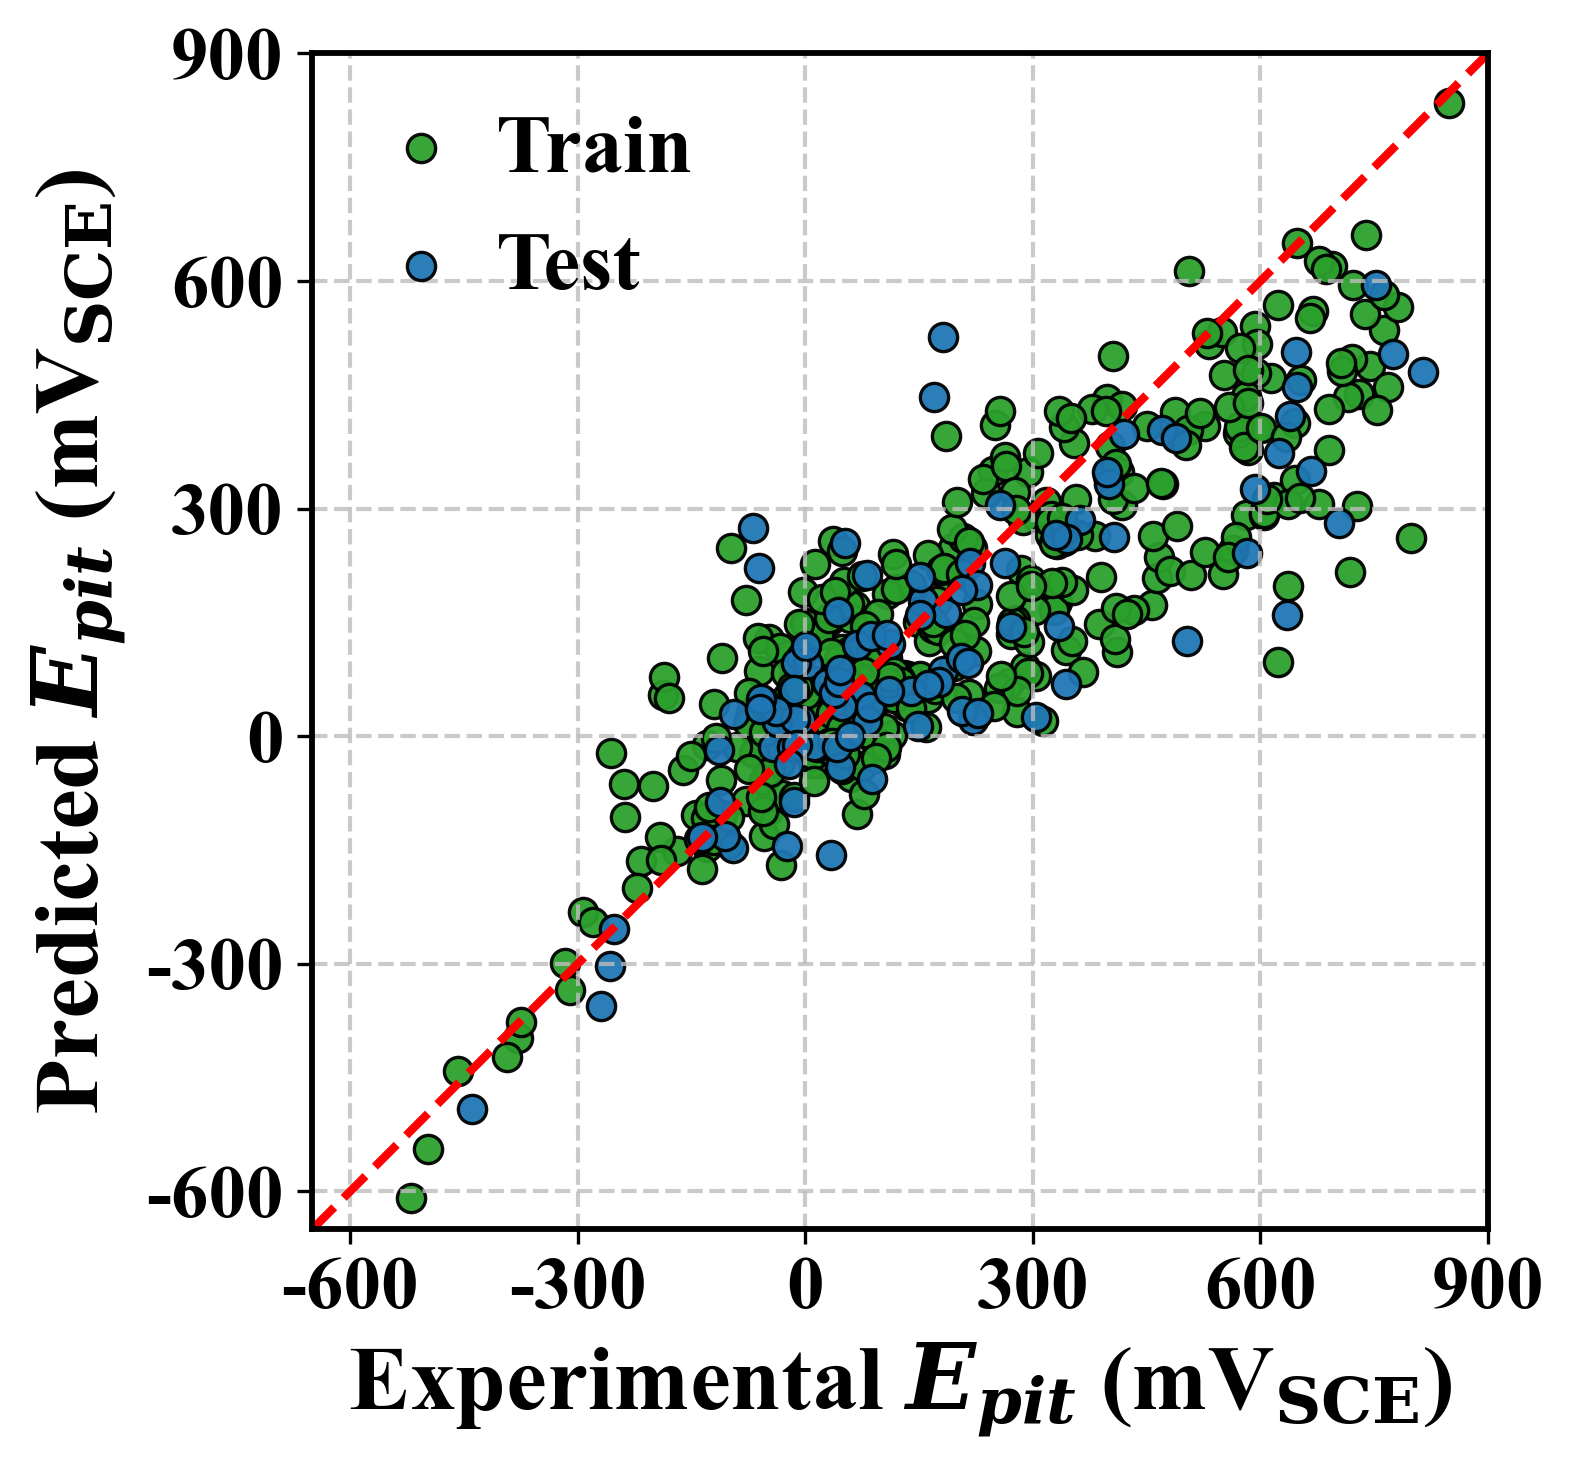

In [73]:
preds_train, trues_train = evaluate_model(model, train_loader, y_scaler)
preds_test, trues_test = evaluate_model(model, test_loader, y_scaler)

plot_parity_train_test(trues_train, preds_train, trues_test, preds_test)

In [9]:
X_scaled = scaler.transform(X)
y_scaled = y_scaler.transform(y.to_numpy().reshape(-1, 1)).flatten()

In [ ]:
def cross_val_predict_pytorch(X, y, y_scaler, k=5, batch_size=64, num_epochs=600, patience=80, l1_lambda=0.01, lr=1e-3):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    y_preds_all = np.zeros_like(y)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n==== Fold {fold + 1}/{k} ====")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        train_dataset = TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.float32)
        )
        val_dataset = TensorDataset(
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_val, dtype=torch.float32)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        model = RobustNN(input_dim=X_train.shape[1])
        trained_model = train_model(
            model, train_loader, val_loader,
            num_epochs=num_epochs,
            patience=patience,
            l1_lambda=l1_lambda,
            lr=lr
        )
        trained_model.eval()
        preds = []
        with torch.no_grad():
            for X_batch, _ in val_loader:
                output = trained_model(X_batch).squeeze()
                preds.append(output.cpu().numpy())
        preds = np.concatenate(preds)
        y_preds_all[val_idx] = preds
    y_preds_real = y_scaler.inverse_transform(y_preds_all.reshape(-1, 1)).ravel()
    y_true_real = y_scaler.inverse_transform(y.reshape(-1, 1)).ravel()

    return y_true_real, y_preds_real

In [ ]:
def plot_parity_cv(
    y_true, y_pred,
    s=46,
    lw_edge=0.8,
    lw_diag=2.0,
    legend_loc='upper left',
    title=None
):
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'   
    plt.rcParams['axes.unicode_minus'] = False          

    fig, ax = plt.subplots(figsize=(6.8, 5), dpi=300)

    ax.scatter(y_true, y_pred, s=s, c='violet',
               edgecolors='k', linewidths=lw_edge,
               label='CV', alpha=0.95)
    lo, hi = -600, 900
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_yticks(np.arange(lo, hi + 100, 300))
    ax.set_xticks(np.arange(lo, hi + 100, 300))
    ax.set_aspect('equal', adjustable='box')
    ax.set_box_aspect(1)

    ax.plot([lo, hi], [lo, hi], color='red', linestyle='--', lw=lw_diag)
    ax.set_xlabel(r'Experimental $\boldsymbol{E}_{\mathrm{\boldsymbol{pit}}}$ (mV$_{\mathbf{SCE}}$)',
                fontsize=22, fontweight='bold')
    ax.set_ylabel(r'Predicted $\boldsymbol{E}_{\mathrm{\boldsymbol{pit}}}$ (mV$_{\mathbf{SCE}}$)',
                fontsize=22, fontweight='bold')

    ax.grid(True, which='major', linestyle='--', linewidth=1.0,
            color='#bdbdbd', alpha=0.8)
    ax.minorticks_off()
    ax.tick_params(labelsize=18)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')
    for spine in ax.spines.values():
        spine.set_linewidth(1.4)
    leg = ax.legend(
        loc=legend_loc,
        frameon=False,
        fontsize=20,
        handletextpad=0.3,    
        handlelength=1.2,     
        borderaxespad=0.3     
    )
    for t in leg.get_texts():
        t.set_fontweight('bold')

    plt.tight_layout(rect=[0, 0, 1, 0.92])

    return fig, ax


In [ ]:
y_true_cv, y_pred_cv = cross_val_predict_pytorch(
    X_scaled, y_scaled,
    y_scaler=y_scaler,
    k=5
)

(<Figure size 2040x1500 with 1 Axes>,
 <Axes: xlabel='Experimental $\\boldsymbol{E}_{\\mathrm{\\boldsymbol{pit}}}$ (mV$_{\\mathbf{SCE}}$)', ylabel='Predicted $\\boldsymbol{E}_{\\mathrm{\\boldsymbol{pit}}}$ (mV$_{\\mathbf{SCE}}$)'>)

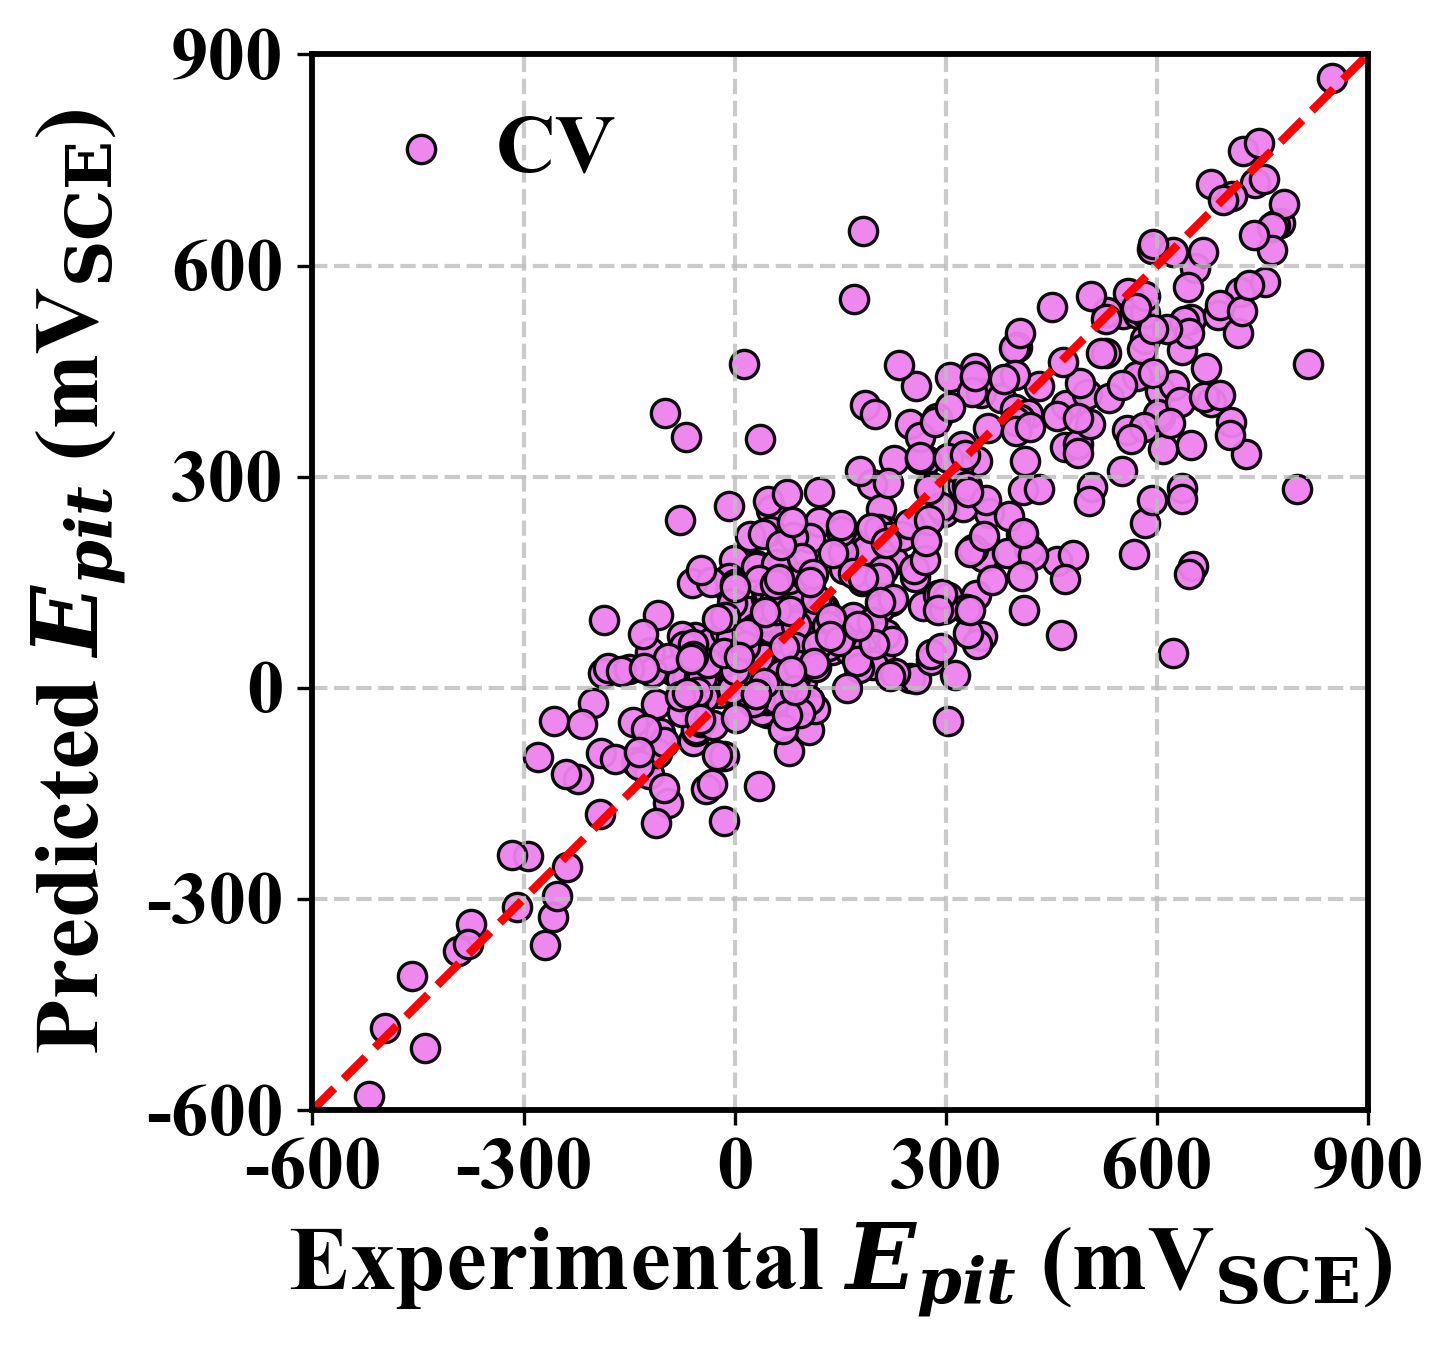

In [71]:
plot_parity_cv(y_true_cv, y_pred_cv)

In [ ]:
def _make_loader(X, y, batch_size=64, shuffle=True):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32).view(-1)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

def evaluate_robustnn_across_splits(
    X, y,
    test_sizes=(0.1, 0.2, 0.3, 0.4, 0.5),
    n_repeats=30,
    random_state=42,
    batch_size=32,
    val_size=0.2,
    num_epochs=600,
    patience=80,
    l1_lambda=0.001,
    lr=1e-3,
    x_scaler_cls=MinMaxScaler,
    y_scaler_cls=MinMaxScaler,
):
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32).ravel()

    rng = np.random.RandomState(random_state)
    results = []

    for ts in test_sizes:
        r2_list, rmse_list = [], []
        seeds = rng.randint(0, 10_000_000, size=n_repeats)

        for seed in seeds:
            np.random.seed(seed)
            torch.manual_seed(seed)
            X_tr0, X_te, y_tr0, y_te = train_test_split(
                X, y, test_size=ts, random_state=seed
            )
            X_tr, X_val, y_tr, y_val = train_test_split(
                X_tr0, y_tr0, test_size=val_size, random_state=seed + 1
            )
            x_scaler = x_scaler_cls().fit(X_tr)
            y_scaler = y_scaler_cls().fit(y_tr.reshape(-1, 1))

            X_tr_s  = x_scaler.transform(X_tr)
            X_val_s = x_scaler.transform(X_val)
            X_te_s  = x_scaler.transform(X_te)

            y_tr_s  = y_scaler.transform(y_tr.reshape(-1, 1)).ravel()
            y_val_s = y_scaler.transform(y_val.reshape(-1, 1)).ravel()
            y_te_s  = y_scaler.transform(y_te.reshape(-1, 1)).ravel()

            train_loader = _make_loader(X_tr_s, y_tr_s, batch_size=batch_size, shuffle=True)
            val_loader   = _make_loader(X_val_s, y_val_s, batch_size=batch_size, shuffle=False)
            test_loader  = _make_loader(X_te_s, y_te_s, batch_size=batch_size, shuffle=False)
            model = RobustNN(input_dim=X.shape[1])

            model = train_model(
                model, train_loader, val_loader,
                num_epochs=num_epochs, patience=patience,
                l1_lambda=l1_lambda, lr=lr
            )

            preds_real, trues_real = evaluate_model(model, test_loader, y_scaler)

            rmse = float(np.sqrt(mean_squared_error(trues_real, preds_real)))
            r2   = float(r2_score(trues_real, preds_real))
            rmse_list.append(rmse)
            r2_list.append(r2)

        results.append({
            "test_size": ts,
            "R2_mean":  np.mean(r2_list),
            "R2_std":   np.std(r2_list, ddof=1),
            "RMSE_mean": np.mean(rmse_list),
            "RMSE_std":  np.std(rmse_list, ddof=1),
        })

    return pd.DataFrame(results)


In [38]:
results = evaluate_robustnn_across_splits(X,y)
results

RMSE: 164.0343
R2: 0.6199
RMSE: 162.8389
R2: 0.6400
RMSE: 167.1108
R2: 0.5421
RMSE: 135.4286
R2: 0.7660
RMSE: 153.0903
R2: 0.7160
RMSE: 167.5504
R2: 0.6305
RMSE: 168.9213
R2: 0.6442
RMSE: 156.8473
R2: 0.7347
RMSE: 165.1301
R2: 0.6446
RMSE: 184.7449
R2: 0.5823
RMSE: 115.2899
R2: 0.8330
RMSE: 144.1328
R2: 0.7195
RMSE: 124.4260
R2: 0.6837
RMSE: 164.5877
R2: 0.5451
RMSE: 134.5062
R2: 0.7994
RMSE: 133.4174
R2: 0.6703
RMSE: 119.9496
R2: 0.7651
RMSE: 146.7175
R2: 0.6816
RMSE: 162.7407
R2: 0.6157
RMSE: 122.6953
R2: 0.7523
RMSE: 158.7496
R2: 0.6707
RMSE: 149.0930
R2: 0.6989
RMSE: 163.2679
R2: 0.6983
RMSE: 151.4213
R2: 0.6045
RMSE: 137.1582
R2: 0.7646
RMSE: 145.9977
R2: 0.7043
RMSE: 157.7396
R2: 0.6767
RMSE: 142.7689
R2: 0.4679
RMSE: 100.7709
R2: 0.8433
RMSE: 117.9698
R2: 0.8429
RMSE: 146.7942
R2: 0.6653
RMSE: 152.3227
R2: 0.6752
RMSE: 137.0721
R2: 0.7313
RMSE: 155.9805
R2: 0.6010
RMSE: 151.6038
R2: 0.7221
RMSE: 147.0697
R2: 0.7247
RMSE: 163.8688
R2: 0.5948
RMSE: 165.0990
R2: 0.5906
RMSE: 122.77

,test_size,R2_mean,R2_std,RMSE_mean,RMSE_std
0,0.1,0.685259,0.090245,147.303231,19.694282
1,0.2,0.689365,0.054013,145.613670,12.842931
2,0.3,0.711231,0.033780,141.641687,9.009364
3,0.4,0.689854,0.039363,147.081019,9.224618
4,0.5,0.665879,0.035038,153.998392,7.876340


# Plot

In [211]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 18

In [ ]:
def plot_r2(x_values, means, stds):
    x = np.array(x_values, dtype=float)
    if x.max() <= 1.0:
        x = x * 100.0

    colors = {
        'XGBoost': '#000000',   
        'RF'     : '#1f77b4',   
        'SVR'    : '#d62728',   
        'MLP': '#2ca02c',  
    }
    markers = {
        'XGBoost': 's',   
        'RF'     : 'o',   
        'SVR'    : '^',   
        'MLP': 'D',  
    }

    fig, ax = plt.subplots(figsize=(6.8, 5), dpi=300)
    n = 256
    grad = np.linspace(0, 1, n).reshape(n, 1, 1)

    bottom_color = np.array([0.92, 0.90, 0.98])  
    top_color    = np.array([1.0, 1.0, 1.0])     
    gradient = bottom_color * (1 - grad) + top_color * grad

    ax.imshow(gradient, extent=[x.min()-5, x.max()+5, 0.5, 0.9],
            aspect='auto', zorder=-2, origin='lower')

    for model in ['XGBoost', 'RF', 'SVR', 'MLP']:
        if model not in means: 
            continue
        y = np.array(means[model], dtype=float)
        yerr = np.array(stds.get(model, np.zeros_like(y)), dtype=float)
        lw = 3 if model == 'MLP' else 1.2

        ax.errorbar(
            x, y, yerr=yerr,
            fmt=markers[model]+'-', 
            color=colors[model],
            ecolor=colors[model],
            elinewidth=1.0,
            capsize=3.0,
            markersize=5,
            linewidth=lw,
            label=model
        )

    ax.set_xlabel("The proportion of testing set (%)", fontsize=22, fontweight='bold')
    ax.set_ylabel(r"$R^2$", fontsize=22, fontweight='bold')
    ax.tick_params(axis='both', labelsize=18, width=1.2)
    ax.set_xticks([10, 20, 30, 40, 50])
    ax.set_xlim(5, 55)
    # ax.set_ylim(0, 1)
    # yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_ylim(0.5, 0.9)
    yticks = [0.5, 0.6, 0.7, 0.8, 0.9]
    ax.set_yticks(yticks)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')


    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.tick_params(direction='in', length=4, width=1)


    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(
        handles, labels,
        loc='upper left', bbox_to_anchor=(0.02, 0.98),
        ncol=2,
        frameon=False,
        fontsize=12, prop={'weight': 'bold'},  
        handlelength=2.0, handleheight=1.0,    
        markerscale=0.9,                       
        columnspacing=0.4, handletextpad=0.2,  
        borderaxespad=0.2                      
    )

    for legobj in legend.legendHandles:
        legobj.set_linewidth(2.0)
    # ax.legend(loc='upper left', frameon=False, fontsize=10, handlelength=2)

    plt.tight_layout()
    return fig, ax

In [232]:
x_vals = [0.1, 0.2, 0.3, 0.4, 0.5]

models = ["XGBoost", "RF", "SVR", "MLP"]
means = {m: df_table_1.loc[f"{m} Mean"].values for m in models}
stds  = {m: df_table_1.loc[f"{m} Std"].values for m in models}


/var/folders/_7/d378l6gn42d_dg0qww9lhxvw0000gp/T/ipykernel_49945/233248459.py:102: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend.legendHandles:


(<Figure size 2040x1500 with 1 Axes>,
 <Axes: xlabel='The proportion of testing set (%)', ylabel='$R^2$'>)

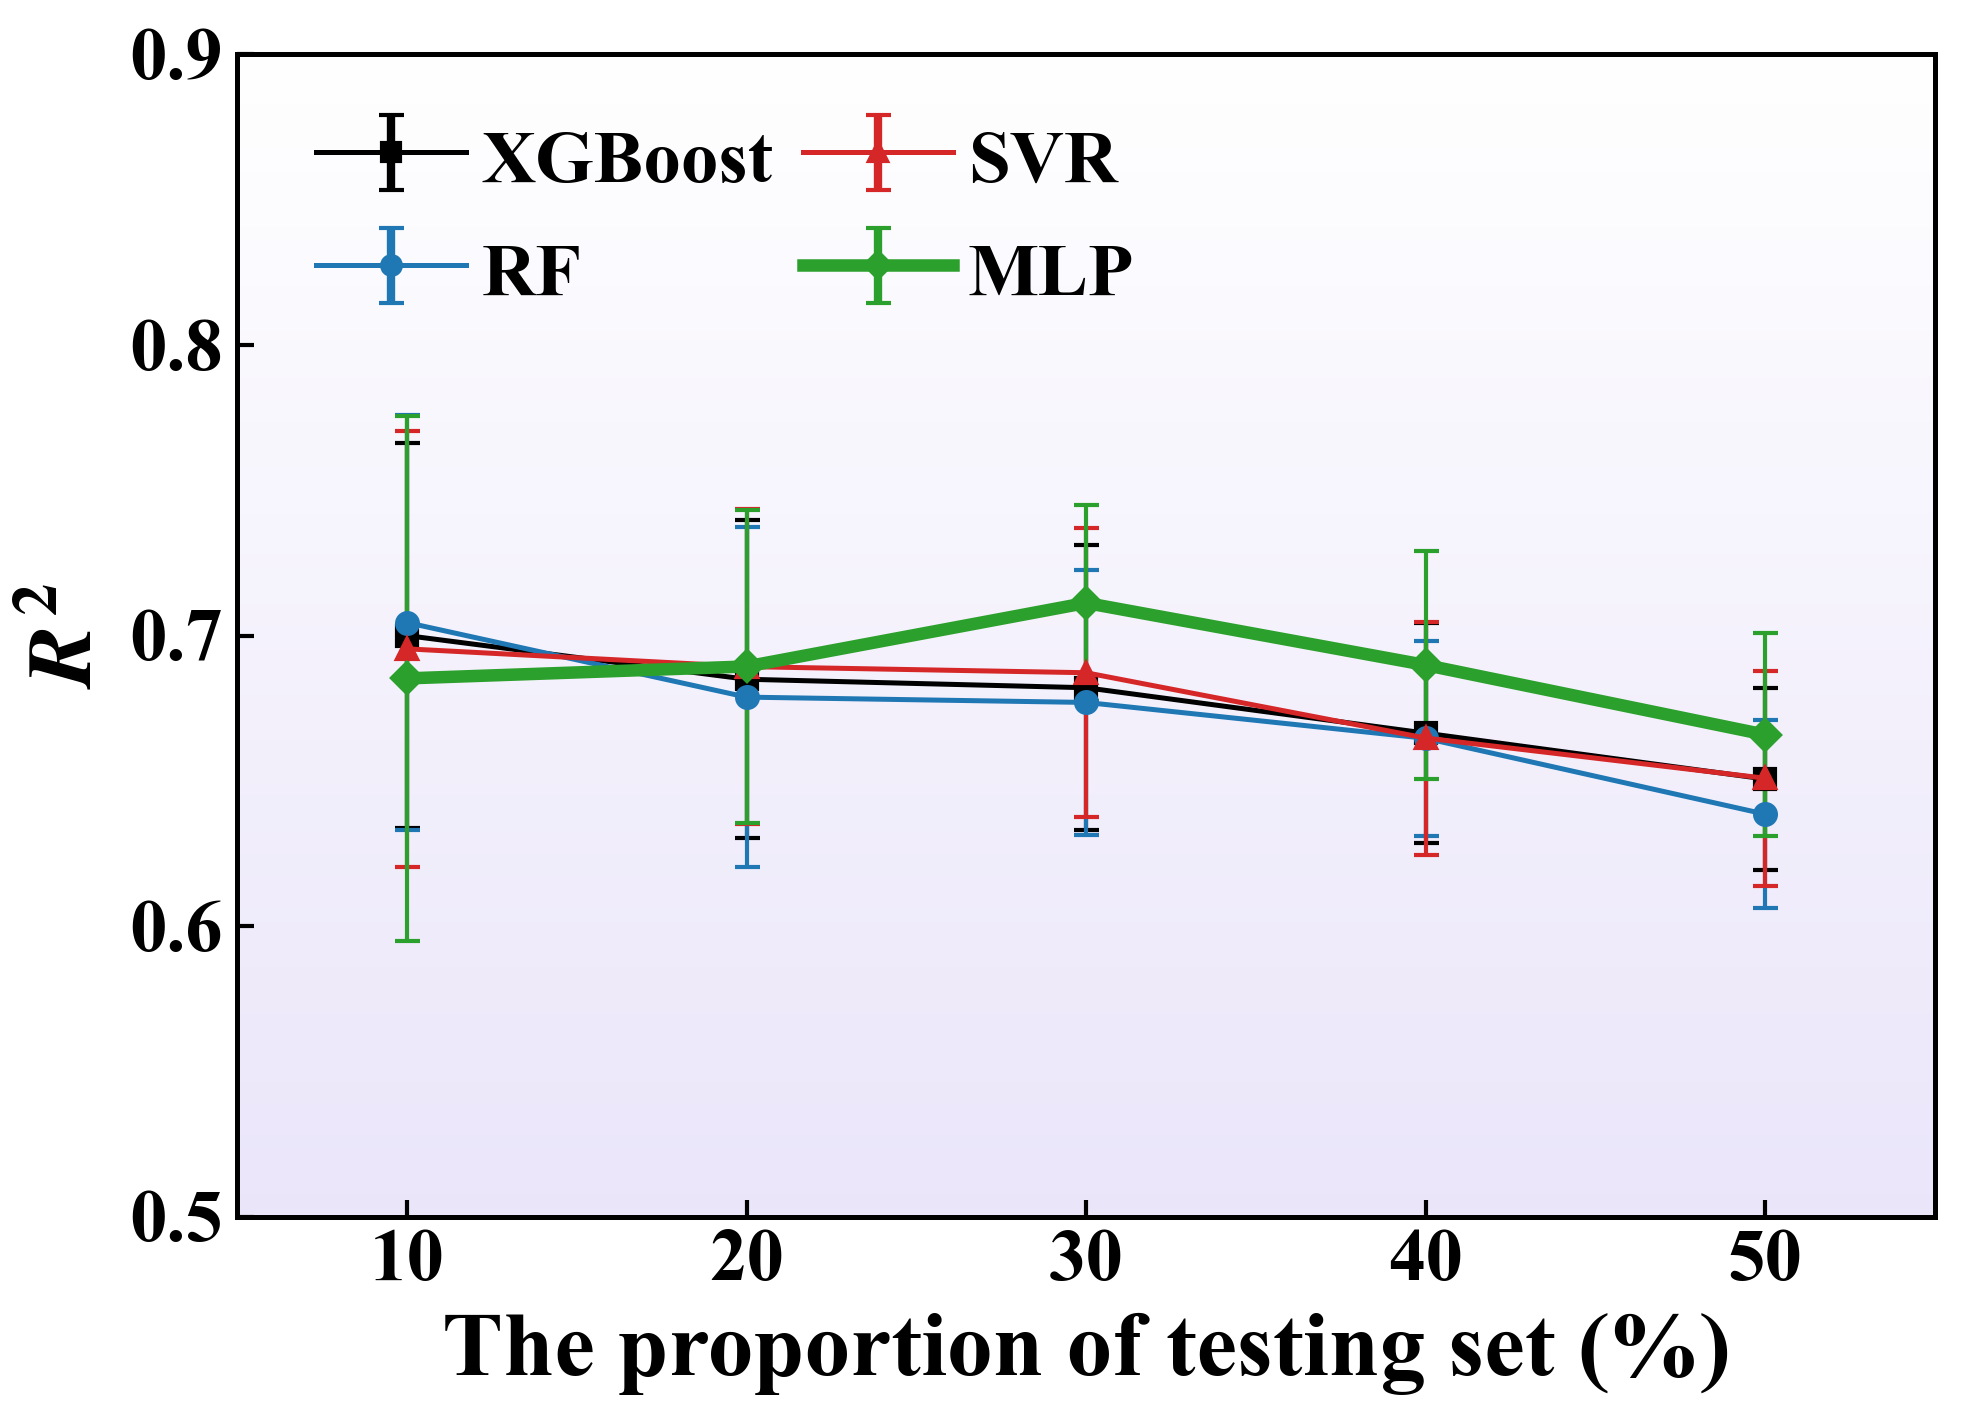

In [ ]:
plot_r2(x_vals, means, stds)

In [216]:
x_vals = [0.1, 0.2, 0.3, 0.4, 0.5]

models = ["XGBoost", "RF", "SVR", "MLP"]
means = {m: df_table.loc[f"{m} Mean"].values for m in models}
stds  = {m: df_table.loc[f"{m} Std"].values for m in models}

/var/folders/_7/d378l6gn42d_dg0qww9lhxvw0000gp/T/ipykernel_49945/2940431528.py:102: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend.legendHandles:


(<Figure size 2040x1500 with 1 Axes>,
 <Axes: xlabel='The proportion of testing set (%)', ylabel='$R^2$'>)

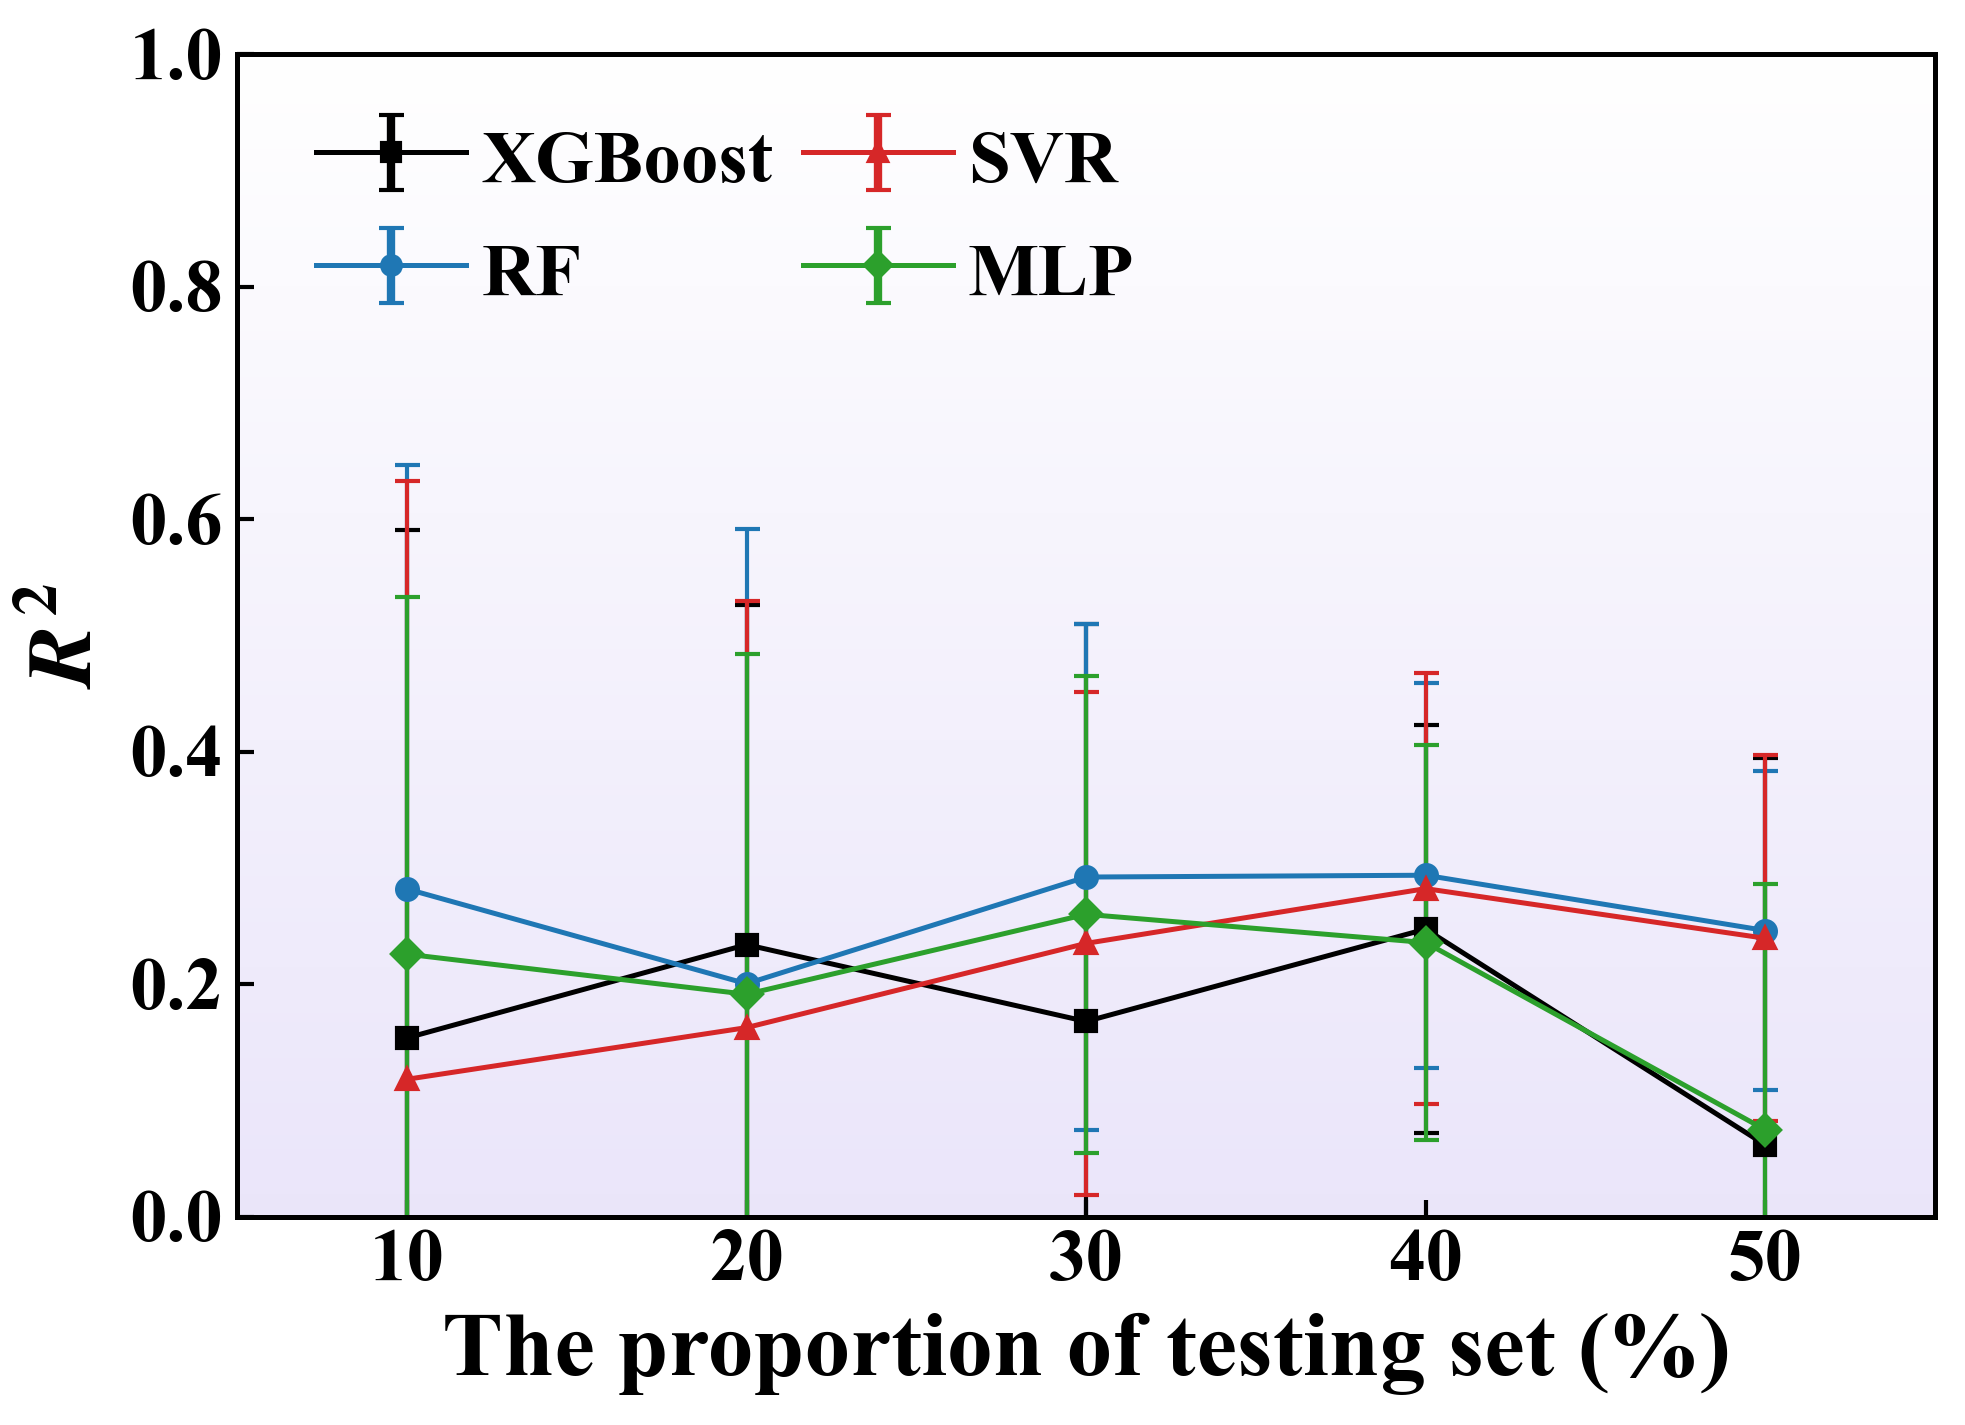

In [229]:
plot_r2_like_fig1(x_vals, means, stds)

In [ ]:
def plot_rmse(x_values, means, stds):
    x = np.array(x_values, dtype=float)
    if x.max() <= 1.0:
        x = x * 100.0
    colors = {'XGBoost': '#000000', 'RF':'#1f77b4', 'SVR':'#d62728', 'MLP':'#2ca02c'}
    markers = {'XGBoost': 's', 'RF': 'o', 'SVR': '^', 'MLP': 'D'}

    fig, ax = plt.subplots(figsize=(6.8, 5), dpi=300)
    n = 256
    grad = np.linspace(0, 1, n).reshape(n, 1, 1)
    grad = grad**(0.5)

    bottom_color = np.array([0.88, 0.95, 0.88])  
    top_color    = np.array([1.0, 1.0, 1.0])     
    gradient = bottom_color * (1 - grad) + top_color * grad

    ax.imshow(gradient, extent=[x.min()-5, x.max()+5, 120, 330],
            aspect='auto', zorder=-2, origin='lower')

    for model in ['XGBoost', 'RF', 'SVR', 'MLP']:
        if model not in means:
            continue
        y = np.asarray(means[model], float)
        yerr = np.asarray(stds.get(model, np.zeros_like(y)), float)
        lw = 3 if model == 'MLP' else 1.2
        ax.errorbar(
            x, y, yerr=yerr,
            fmt=markers[model]+'-',  
            color=colors[model],
            ecolor=colors[model],
            elinewidth=1.0,
            capsize=3.0,
            markersize=5,
            linewidth=lw,
            label=model
        )

    ax.set_xlabel("The proportion of testing set (%)", fontsize=22, fontweight='bold')
    ax.set_ylabel("RMSE", fontsize=22, fontweight='bold')
    ax.set_xticks([10, 20, 30, 40, 50])
    ax.set_xlim(x.min()-5, x.max()+5)
    ax.set_ylim(120, 200)  
    ax.set_yticks([120, 140, 160, 180, 200])  # 手动设置
    # ax.set_yticks([120, 150, 180, 210, 240, 270, 300, 330])  # 手动设置

    ax.tick_params(axis='both', labelsize=18, width=1.2, direction='in', length=4)
    for lab in ax.get_xticklabels() + ax.get_yticklabels():
        lab.set_fontweight('bold')

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(
        handles, labels,
        loc='upper left', bbox_to_anchor=(0.02, 0.98),
        ncol=2,
        frameon=False,
        fontsize=12, prop={'weight': 'bold'},  
        handlelength=2.0, handleheight=1.0,   
        markerscale=0.9,                      
        columnspacing=0.4, handletextpad=0.2, 
        borderaxespad=0.2                     
    )
    for legobj in legend.legendHandles:
        legobj.set_linewidth(2.0)
    plt.tight_layout()
    return fig, ax

In [235]:
x_vals = [0.1, 0.2, 0.3, 0.4, 0.5]

models = ["XGBoost", "RF", "SVR", "MLP"]
means = {m: df_table_rmse.loc[f"{m} Mean"].values for m in models}
stds  = {m: df_table_rmse.loc[f"{m} Std"].values for m in models}

/var/folders/_7/d378l6gn42d_dg0qww9lhxvw0000gp/T/ipykernel_49945/2909531770.py:86: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend.legendHandles:


(<Figure size 2040x1500 with 1 Axes>,
 <Axes: xlabel='The proportion of testing set (%)', ylabel='RMSE'>)

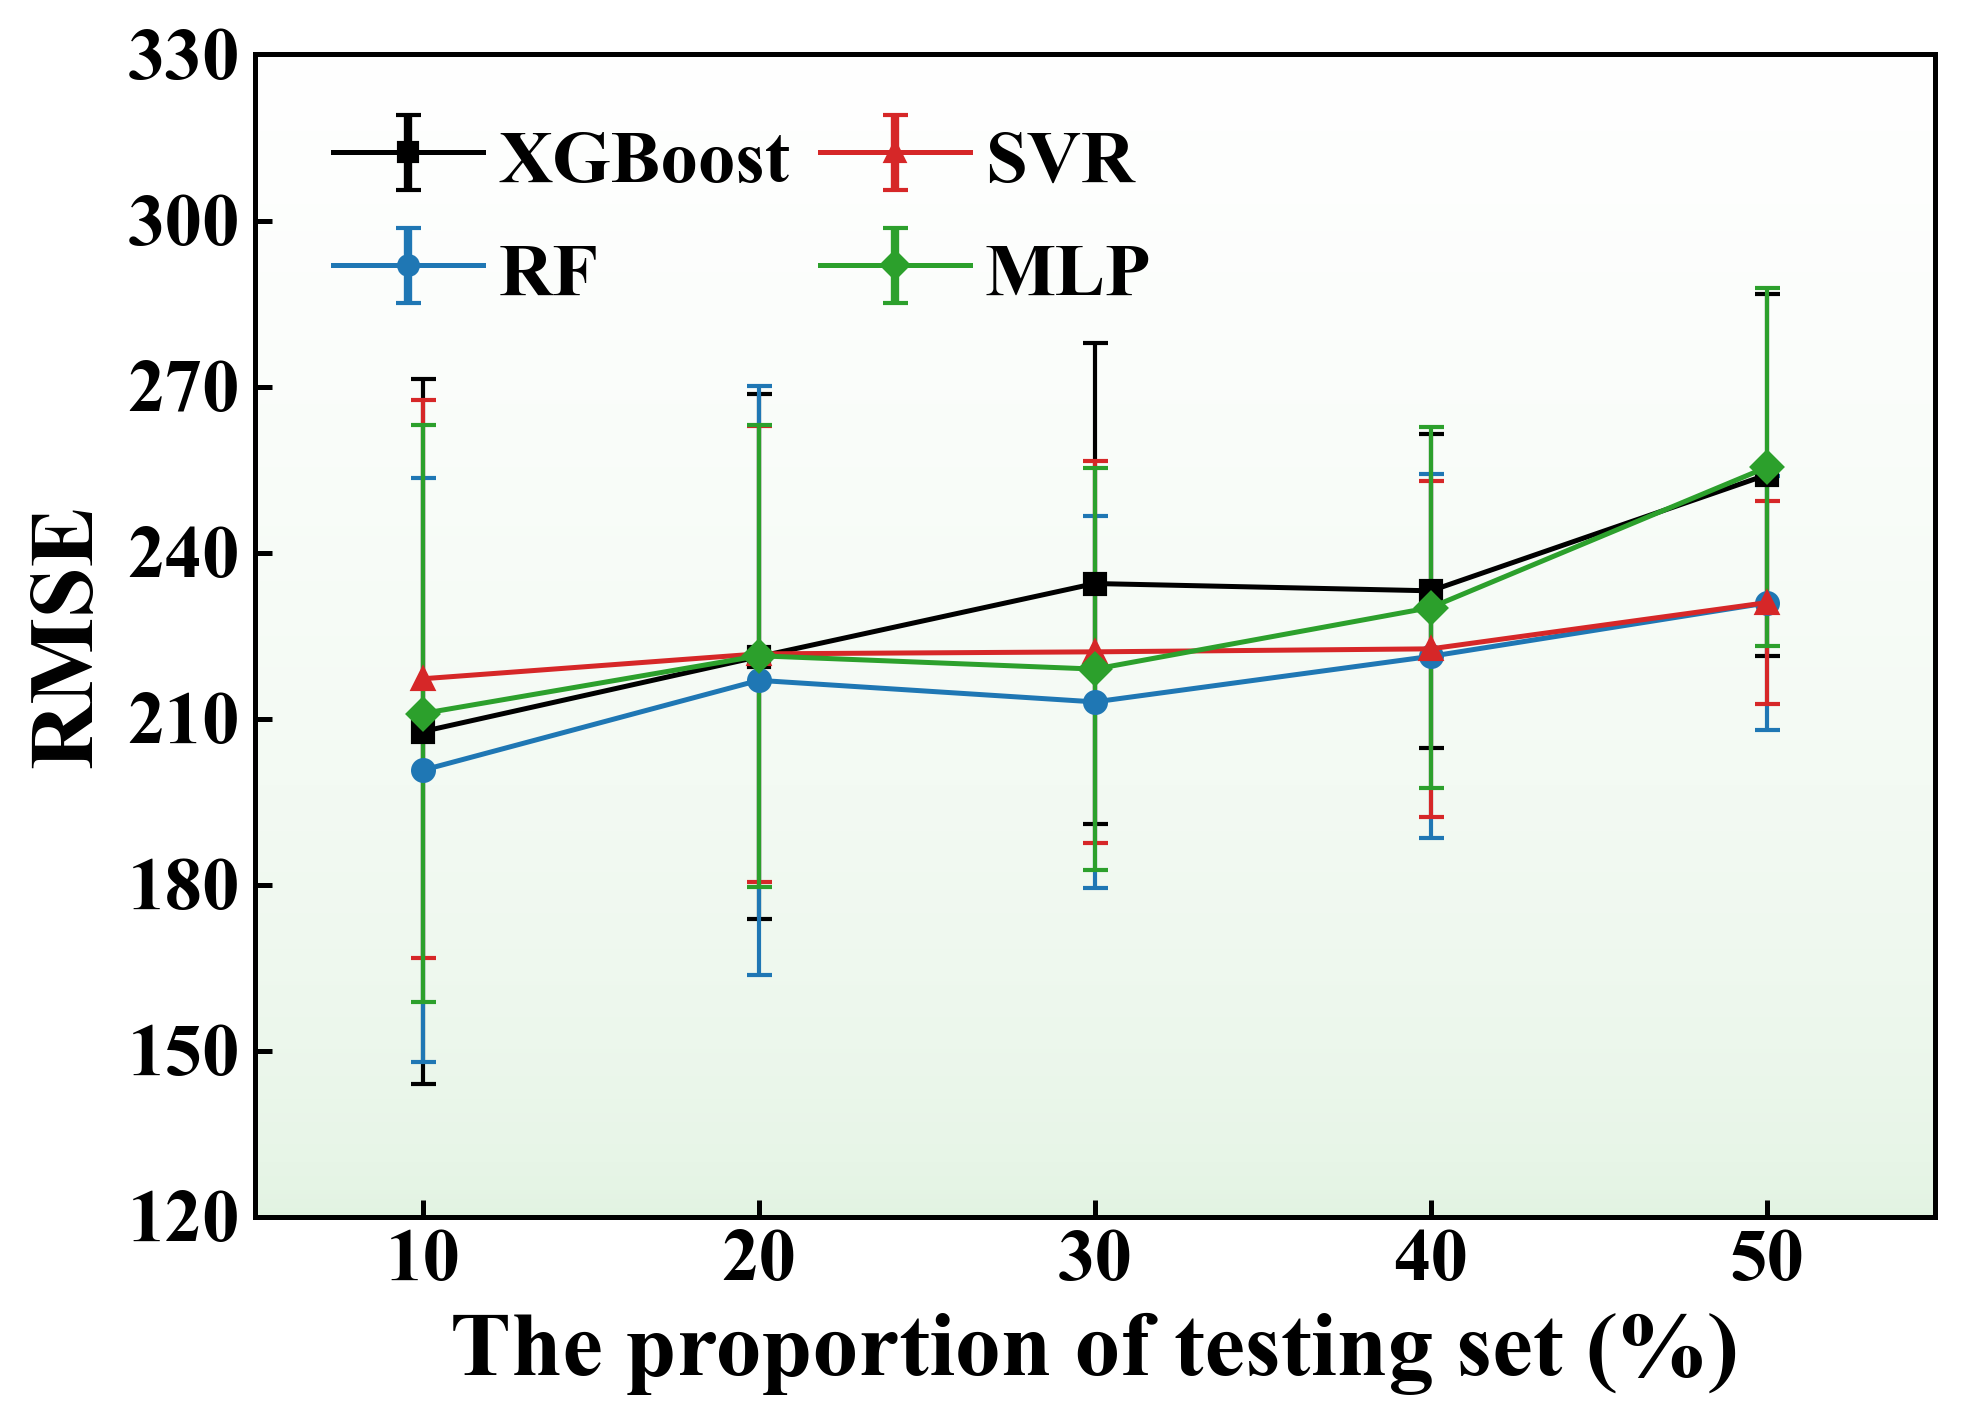

In [236]:
plot_rmse_like_fig1(x_vals, means, stds)

In [238]:
x_vals = [0.1, 0.2, 0.3, 0.4, 0.5]

models = ["XGBoost", "RF", "SVR", "MLP"]
means = {m: df_table_rmse_1.loc[f"{m} Mean"].values for m in models}
stds  = {m: df_table_rmse_1.loc[f"{m} Std"].values for m in models}

/var/folders/_7/d378l6gn42d_dg0qww9lhxvw0000gp/T/ipykernel_49945/241810128.py:86: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend.legendHandles:


(<Figure size 2040x1500 with 1 Axes>,
 <Axes: xlabel='The proportion of testing set (%)', ylabel='RMSE'>)

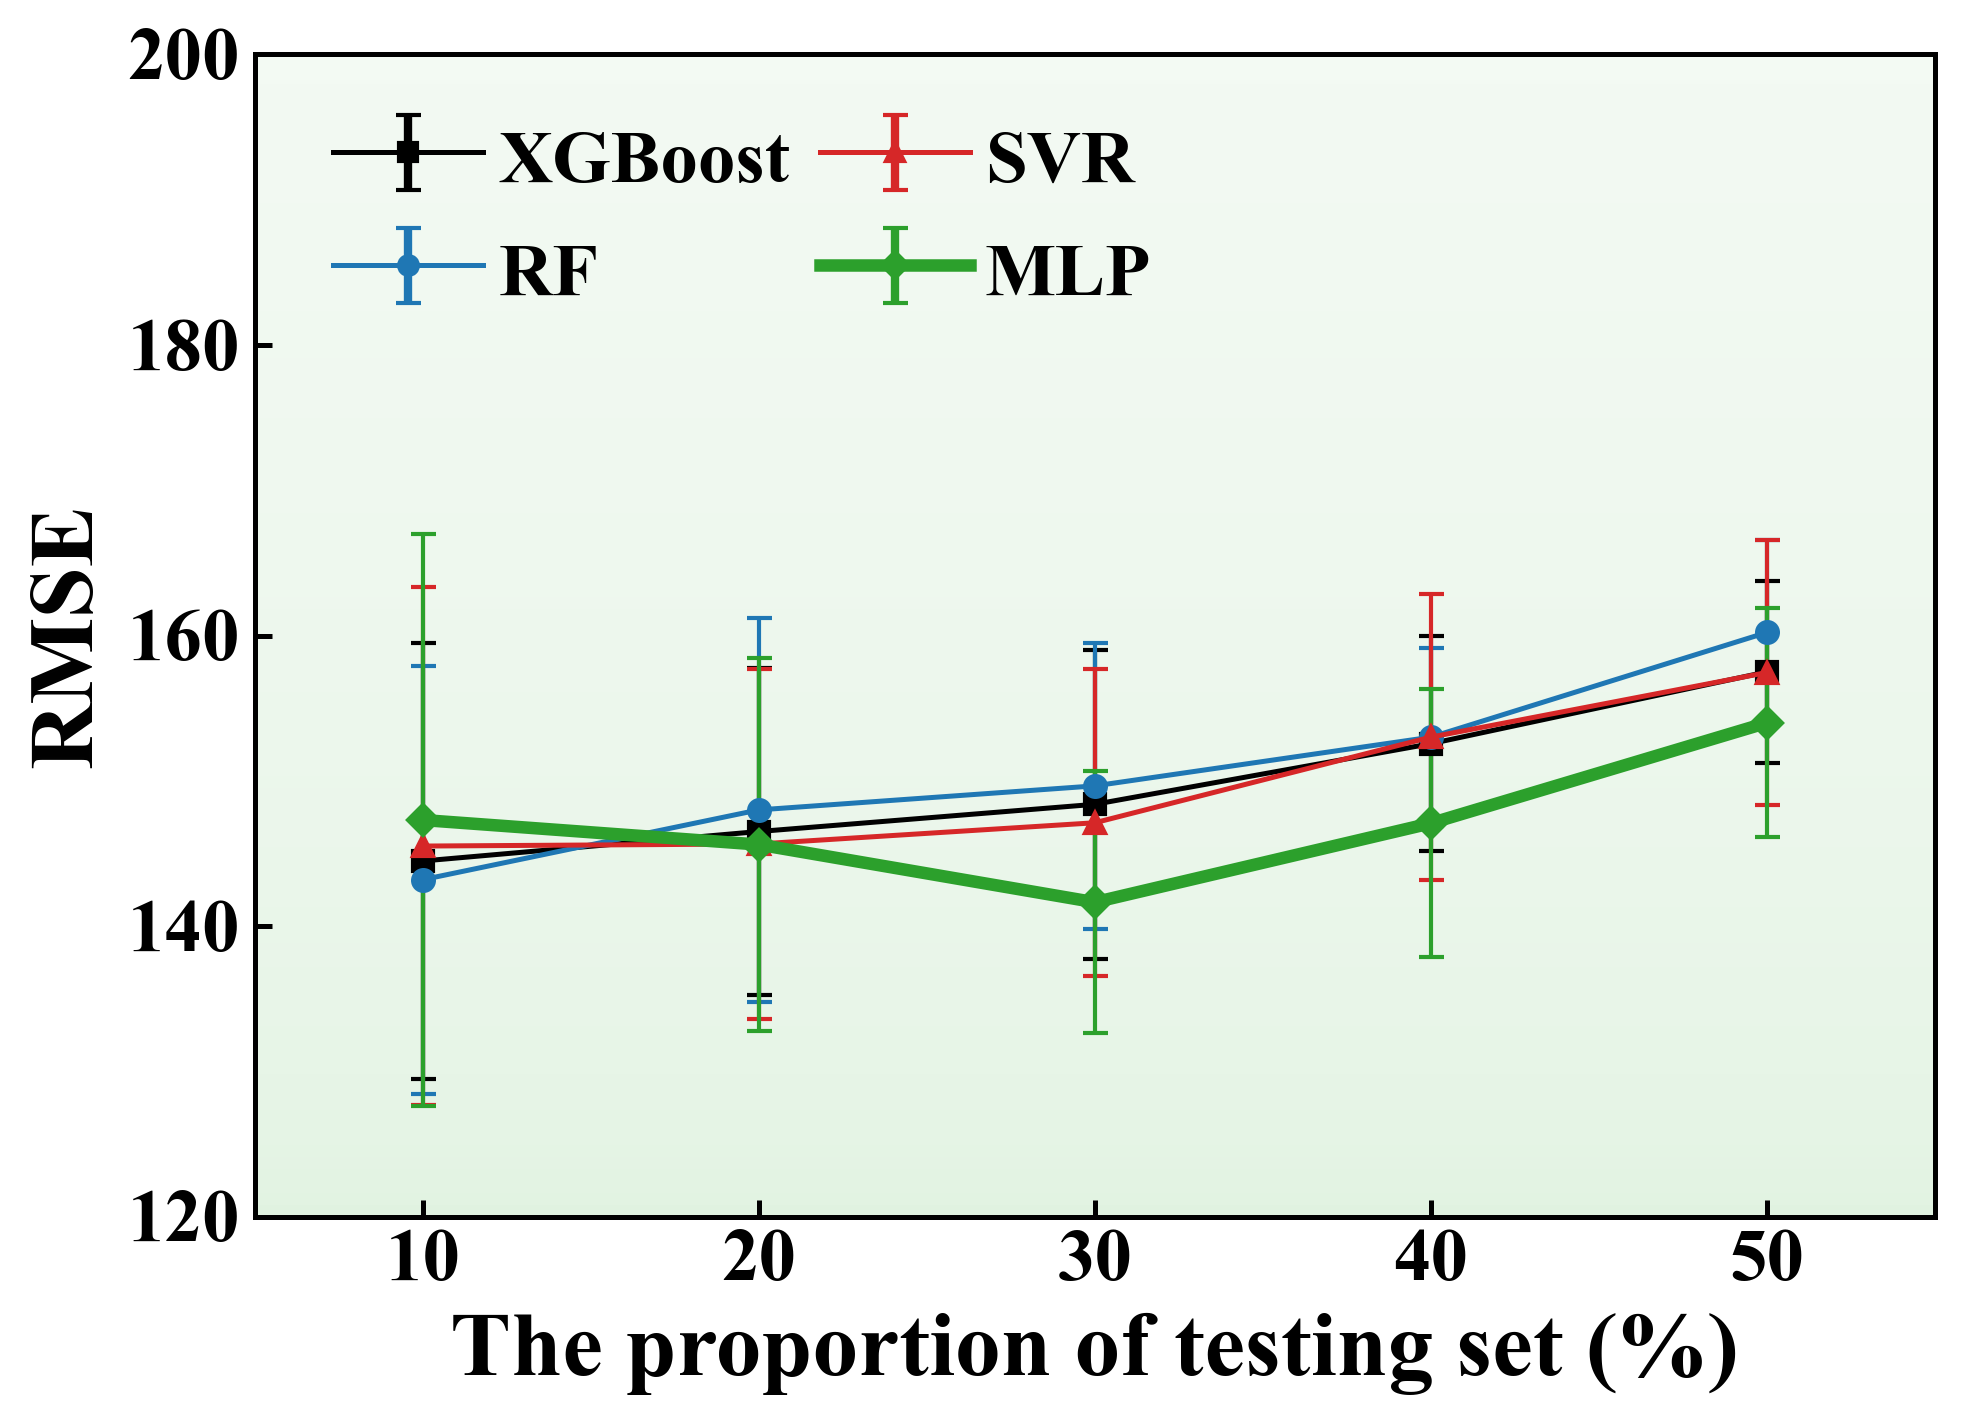

In [239]:
plot_rmse_like_fig1(x_vals, means, stds)